# LangGraph Workflows and Agents with Groq

This notebook demonstrates various LangGraph workflow patterns using the Groq model instead of Anthropic Claude. It includes examples of:

1. **Setup and Configuration** - Groq model initialization
2. **Building Blocks** - Augmented LLM with structured outputs and tool calling
3. **Prompt Chaining** - Sequential LLM calls with gates
4. **Parallelization** - Concurrent LLM operations
5. **Routing** - Conditional workflow paths
6. **Orchestrator-Worker** - Master-worker patterns
7. **Evaluator-Optimizer** - Iterative improvement loops
8. **Agent** - Tool-calling agents with dynamic decision making

Based on the LangGraph tutorial: https://langchain-ai.github.io/langgraph/tutorials/workflows/


## 🎓 Understanding Workflows vs Agents

According to the [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/), there's an important distinction between **workflows** and **agents**, as explained in Anthropic's "Building Effective Agents" blog post:

> **"Workflows are systems where LLMs and tools are orchestrated through predefined code paths. Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks."**

### 🔄 Workflows (Predefined Paths):
- **Structured**: Follow predetermined execution paths
- **Predictable**: Same input types → same execution flow
- **Controlled**: Developer defines exactly how tasks are accomplished
- **Examples**: Prompt chaining, parallelization, routing, orchestrator-worker

### 🤖 Agents (Dynamic Control):
- **Autonomous**: LLM decides its own execution path
- **Adaptive**: Different strategies for different situations
- **Flexible**: Can handle unpredictable, multi-step problems
- **Examples**: Tool-calling agents, ReAct patterns

### 📊 When to Choose Each:
| **Use Workflows When:** | **Use Agents When:** |
|------------------------|---------------------|
| ✅ Predictable task structure | ✅ Open-ended problems |
| ✅ Need guaranteed execution paths | ✅ Dynamic decision making required |
| ✅ Quality control through gates | ✅ Unpredictable number of steps |
| ✅ Performance optimization needed | ✅ Trust in LLM reasoning |

**This notebook covers both paradigms, starting with structured workflows and progressing to autonomous agents.**


## 1. Setup and Configuration

First, let's install dependencies and set up the Groq model.


In [27]:
# Install required packages if not already installed
# !pip install langchain-groq langgraph langchain-core pydantic

import os
import getpass
from typing import Literal, List
from typing_extensions import TypedDict

# Core LangChain imports
from langchain_core.messages import (
    SystemMessage, 
    HumanMessage, 
    ToolMessage, 
    BaseMessage
)
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# LangGraph imports
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.func import entrypoint, task

# Pydantic for structured outputs
from pydantic import BaseModel, Field

# For visualization
from IPython.display import Image, display
import json


In [50]:
# Initialize Groq LLM
# Using Mixtral or Llama models available on Groq
model_name = "llama-3.3-70b-versatile"  # or "mixtral-8x7b-32768", "llama3-70b-8192", "llama3-8b-8192"
llm = ChatGroq(
    model=model_name,
    temperature=0.1,
    max_tokens=1000,
    api_key="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"
)

print("✅ Groq model initialized successfully!")
print(f"Model: {model_name}")
print(f"Temperature: {llm.temperature}")
print(f"Max tokens: {llm.max_tokens}")


✅ Groq model initialized successfully!
Model: llama-3.3-70b-versatile
Temperature: 0.1
Max tokens: 1000


## 2. Building Blocks: The Augmented LLM

LLMs can be augmented with structured outputs and tool calling capabilities.


In [29]:
# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized for web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Test structured output
print("🔍 Testing Structured Output:")
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(f"Search Query: {output.search_query}")
print(f"Justification: {output.justification}")


🔍 Testing Structured Output:
Search Query: Calcium CT score and high cholesterol relationship
Justification: The user wants to know how Calcium CT score is related to high cholesterol, so a search query is needed to find relevant information.


In [30]:
# Define tools for the LLM
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# Test tool calling
print("🔧 Testing Tool Calling:")
msg = llm_with_tools.invoke("What is 15 times 23?")
print(f"Tool calls: {msg.tool_calls}")
if msg.tool_calls:
    tool_call = msg.tool_calls[0]
    tool = tools_by_name[tool_call["name"]]
    result = tool.invoke(tool_call["args"])
    print(f"Result: {result}")


🔧 Testing Tool Calling:
Tool calls: [{'name': 'multiply', 'args': {'a': 15, 'b': 23}, 'id': 'nfge6j3nf', 'type': 'tool_call'}]
Result: 345


### 📚 Theoretical Background: Prompt Chaining

According to the [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/), **prompt chaining** is a fundamental workflow pattern where:

> **"Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate" in the diagram below) on any intermediate steps to ensure that the process is still on track."**

![Alt text](prompt_chain.png)

#### 🎯 When to Use Prompt Chaining:
- **Fixed Subtasks**: When tasks can be easily and cleanly decomposed into fixed subtasks
- **Quality Control**: Need intermediate validation steps (gates) to ensure process stays on track  
- **Accuracy over Speed**: Trading off latency for higher accuracy by making each LLM call an easier task
- **Sequential Dependencies**: When each step depends on the previous step's output

#### 🔧 Key Components:
1. **Sequential Nodes**: Each node processes output from the previous node
2. **Quality Gates**: Programmatic checks between steps (like our punchline checker)
3. **Conditional Routing**: Different paths based on intermediate results
4. **State Management**: Passing information between sequential steps

#### 💡 Example Use Cases:
- Document analysis → summarization → insight extraction
- Data validation → processing → formatting → output
- Creative content generation → quality review → refinement → final polish

**Let's implement this pattern with a joke improvement workflow:**


## 3. Prompt Chaining

In prompt chaining, each LLM call processes the output of the previous one, with optional gates for quality control.


📝 Prompt Chaining Workflow Created!


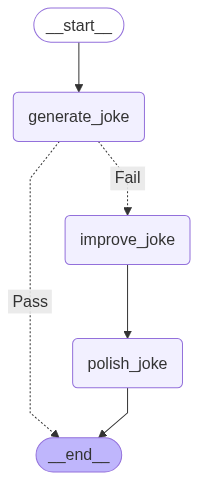

In [31]:
# Graph state for prompt chaining
class ChainState(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes for prompt chaining
def generate_joke(state: ChainState):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: ChainState):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

def improve_joke(state: ChainState):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: ChainState):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Build prompt chaining workflow
chain_workflow = StateGraph(ChainState)

# Add nodes
chain_workflow.add_node("generate_joke", generate_joke)
chain_workflow.add_node("improve_joke", improve_joke)
chain_workflow.add_node("polish_joke", polish_joke)

# Add edges
chain_workflow.add_edge(START, "generate_joke")
chain_workflow.add_conditional_edges(
    "generate_joke", 
    check_punchline, 
    {"Fail": "improve_joke", "Pass": END}
)
chain_workflow.add_edge("improve_joke", "polish_joke")
chain_workflow.add_edge("polish_joke", END)

# Compile
chain_app = chain_workflow.compile()

print("📝 Prompt Chaining Workflow Created!")
chain_app


In [32]:
# Test prompt chaining
print("🎭 Testing Prompt Chaining - Joke Generation:")
print("=" * 50)

state = chain_app.invoke({"topic": "cats"})

print("Initial joke:")
print(state["joke"])
print("\n" + "-" * 30 + "\n")

if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n" + "-" * 30 + "\n")
    
    if "final_joke" in state:
        print("Final joke:")
        print(state["final_joke"])
else:
    print("✅ Joke passed quality gate - no improvement needed!")


🎭 Testing Prompt Chaining - Joke Generation:
Initial joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist.

------------------------------

✅ Joke passed quality gate - no improvement needed!


### 📚 Theoretical Background: Parallelization

The [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/) emphasizes parallelization as a critical performance optimization pattern:

#### 🚀 Core Concept:
**Parallelization** allows independent tasks to run simultaneously rather than sequentially, dramatically improving execution speed for workflows with multiple non-dependent operations.

#### 🎯 When to Use Parallelization:
- **Independent Tasks**: When tasks don't depend on each other's outputs
- **Performance Critical**: Need to minimize total execution time
- **Resource Optimization**: Can utilize multiple processing threads/cores
- **Batch Processing**: Multiple similar operations on different data

#### ⚡ Performance Benefits:
- **Speed Improvement**: Can achieve 2-5x faster execution vs sequential
- **Resource Utilization**: Better use of available computing resources
- **Scalability**: Easily add more parallel tasks without redesigning workflow
- **Cost Efficiency**: Reduced total processing time = lower compute costs

#### 🔧 Implementation Pattern:
1. **Fan-out**: Multiple nodes start from the same point (START)
2. **Parallel Execution**: Tasks run concurrently without waiting
3. **Fan-in**: All parallel tasks feed into a synthesis/collection node
4. **Synchronization**: Next step waits for ALL parallel tasks to complete

#### 💡 Real-World Applications:
- Multi-source data gathering (APIs, databases, files)
- Content generation (multiple formats, languages, styles)
- Parallel analysis (sentiment, entities, topics)
- Distributed processing (image recognition, document parsing)

**Let's see parallelization in action with concurrent content generation:**


## 4. Parallelization

**Learning Objective**: Understand how to run multiple LLM calls concurrently for efficiency.

Parallelization allows independent tasks to run simultaneously, significantly improving performance. This is ideal when you have multiple tasks that don't depend on each other's outputs.


⚡ Parallelization Workflow Created!
📚 Key Concept: Multiple nodes can start from the same point and run concurrently


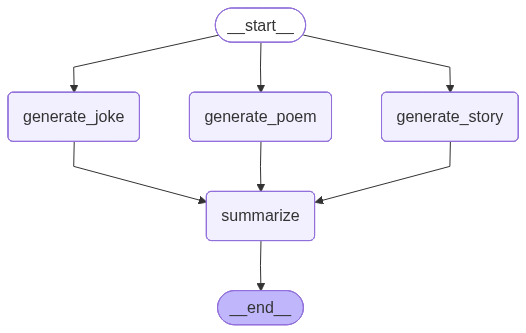

In [33]:
# State for parallelization workflow
class ParallelState(TypedDict):
    topic: str
    joke: str
    poem: str
    story: str
    summary: str

# Parallel generation functions - these will run concurrently
def generate_joke_parallel(state: ParallelState):
    """Generate a joke about the topic"""
    msg = llm.invoke(f"Write a funny joke about {state['topic']}")
    return {"joke": msg.content}

def generate_poem(state: ParallelState):
    """Generate a poem about the topic"""
    msg = llm.invoke(f"Write a short poem about {state['topic']}")
    return {"poem": msg.content}

def generate_story(state: ParallelState):
    """Generate a story about the topic"""
    msg = llm.invoke(f"Write a very short story about {state['topic']}")
    return {"story": msg.content}

def summarize_all(state: ParallelState):
    """Summarize all generated content - runs after parallel tasks complete"""
    content = f"""Joke: {state['joke']}
    
Poem: {state['poem']}

Story: {state['story']}"""
    
    msg = llm.invoke(f"Summarize these creative works about {state['topic']} in 2 sentences:\\n\\n{content}")
    return {"summary": msg.content}

# Build parallel workflow
parallel_workflow = StateGraph(ParallelState)

# Add nodes
parallel_workflow.add_node("generate_joke", generate_joke_parallel)
parallel_workflow.add_node("generate_poem", generate_poem)
parallel_workflow.add_node("generate_story", generate_story)
parallel_workflow.add_node("summarize", summarize_all)

# KEY: Add edges for parallel execution
# All three generation tasks start simultaneously from START
parallel_workflow.add_edge(START, "generate_joke")
parallel_workflow.add_edge(START, "generate_poem")
parallel_workflow.add_edge(START, "generate_story")

# All parallel tasks must complete before summary can run
parallel_workflow.add_edge("generate_joke", "summarize")
parallel_workflow.add_edge("generate_poem", "summarize")
parallel_workflow.add_edge("generate_story", "summarize")

parallel_workflow.add_edge("summarize", END)

# Compile
parallel_app = parallel_workflow.compile()

print("⚡ Parallelization Workflow Created!")
print("📚 Key Concept: Multiple nodes can start from the same point and run concurrently")
parallel_app


In [ ]:
# Test parallelization with timing
print("🚀 Testing Parallelization - Creative Content Generation:")
print("=" * 60)

import time
start_time = time.time()

result = parallel_app.invoke({"topic": "robots"})

end_time = time.time()
print(f"⏱️ Total execution time: {end_time - start_time:.2f} seconds")
print("📝 Notice how all three content types were generated concurrently!\n")

print("😂 JOKE:")
print(result["joke"])
print("\n" + "-" * 40)

print("\n📝 POEM:")
print(result["poem"])
print("\n" + "-" * 40)

print("\n📖 STORY:")
print(result["story"])
print("\n" + "-" * 40)

print("\n📋 SUMMARY:")
print(result["summary"])

print("\n🎯 Training Note: Compare this timing to sequential execution - parallelization can provide 2-3x speedup!")


🚀 Testing Parallelization - Creative Content Generation:
⏱️ Total execution time: 1.02 seconds
📝 Notice how all three content types were generated concurrently!

😂 JOKE:
Why did the robot go on a diet?

Because it wanted to lose some bytes! (get it?)

----------------------------------------

📝 POEM:
Metal minds, with gears so fine,
Whirring, buzzing, all the time.
Their digital hearts, with logic bright,
Shine like stars, in the dark of night.

With limbs of steel, and eyes of gold,
They move and work, with a story to be told.
Their programming, a code so grand,
Guides their actions, with a mechanical hand.

In a world of wires, and circuits so bright,
They live and work, with a robotic might.
Their future uncertain, yet to be seen,
A world of wonder, where robots are serene.

----------------------------------------

📖 STORY:
As the last star in the universe died, a lone robot named Aria stood on a barren planet, her bright blue eyes glowing in the darkness. She held a small, flicker

### 📚 Theoretical Background: Routing

The [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/) describes **routing** as an intelligent workflow pattern for handling diverse inputs:

#### 🧭 Core Concept:
**Routing** creates conditional workflow paths where different types of inputs are automatically directed to specialized handlers, enabling intelligent processing based on content analysis.

#### 🎯 When to Use Routing:
- **Diverse Input Types**: Multiple categories of requests requiring different handling
- **Specialized Processing**: Different strategies needed for different scenarios
- **Intent Classification**: Need to understand user intent before processing
- **Dynamic Workflows**: Workflow path determined at runtime, not design time

#### 🔧 Key Components:
1. **Intent Classifier**: Analyzes input to determine appropriate category/path
2. **Conditional Edges**: Routes based on classification results
3. **Specialized Handlers**: Different nodes optimized for specific input types
4. **Unified Interface**: Single entry point despite multiple processing paths

#### 💡 Business Applications:
- **Customer Service**: Route tickets by urgency, type, department
- **Content Management**: Different processing for text, images, videos
- **Data Processing**: Route by format, source, complexity
- **API Gateways**: Route requests to appropriate microservices

#### 🧠 Classification Strategies:
- **Rule-based**: Keywords, patterns, simple logic
- **ML-based**: Intent classification models
- **LLM-based**: Structured output classification (what we'll use)
- **Hybrid**: Combination of multiple approaches

**Let's implement intelligent routing with intent classification:**


## 5. Routing

**Learning Objective**: Learn how to create conditional workflow paths based on input analysis.

Routing allows workflows to take different paths based on the content or type of input. This enables specialized handling for different scenarios.


🧭 Routing Workflow Created!
📚 Key Concept: Conditional edges allow dynamic workflow paths based on state


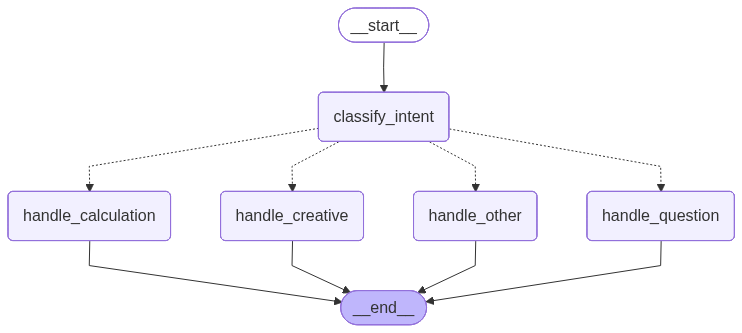

In [35]:
# State for routing workflow
class RoutingState(TypedDict):
    user_input: str
    intent: str
    response: str

# Intent classification schema
class Intent(BaseModel):
    intent: Literal["question", "creative", "calculation", "other"] = Field(
        description="The user's intent category"
    )
    confidence: float = Field(description="Confidence score 0-1")

intent_classifier = llm.with_structured_output(Intent)

def classify_intent(state: RoutingState):
    """Step 1: Classify user intent using structured output"""
    classification = intent_classifier.invoke(
        f"Classify the intent of this user input: '{state['user_input']}'\\n\\n"
        "Categories:\\n"
        "- question: asking for information or explanation\\n"
        "- creative: requesting creative content (stories, poems, etc.)\\n"
        "- calculation: mathematical operations\\n"
        "- other: anything else"
    )
    print(f"🎯 Classified intent: {classification.intent} (confidence: {classification.confidence:.2f})")
    return {"intent": classification.intent}

# Specialized handlers for each intent type
def handle_question(state: RoutingState):
    """Handle informational questions"""
    msg = llm.invoke(
        f"Provide a helpful, informative answer to this question: {state['user_input']}"
    )
    return {"response": f"📚 Information: {msg.content}"}

def handle_creative(state: RoutingState):
    """Handle creative requests"""
    msg = llm.invoke(
        f"Create engaging creative content for this request: {state['user_input']}"
    )
    return {"response": f"🎨 Creative: {msg.content}"}

def handle_calculation(state: RoutingState):
    """Handle mathematical calculations"""
    msg = llm.invoke(
        f"Solve this mathematical problem step by step: {state['user_input']}"
    )
    return {"response": f"🧮 Calculation: {msg.content}"}

def handle_other(state: RoutingState):
    """Handle other requests"""
    msg = llm.invoke(
        f"Respond helpfully to this request: {state['user_input']}"
    )
    return {"response": f"💬 General: {msg.content}"}

# KEY: Routing function determines which path to take
def route_by_intent(state: RoutingState) -> str:
    """Route based on classified intent"""
    intent_map = {
        "question": "handle_question",
        "creative": "handle_creative", 
        "calculation": "handle_calculation",
        "other": "handle_other"
    }
    next_node = intent_map.get(state["intent"], "handle_other")
    print(f"🧭 Routing to: {next_node}")
    return next_node

# Build routing workflow
routing_workflow = StateGraph(RoutingState)

# Add nodes
routing_workflow.add_node("classify_intent", classify_intent)
routing_workflow.add_node("handle_question", handle_question)
routing_workflow.add_node("handle_creative", handle_creative)
routing_workflow.add_node("handle_calculation", handle_calculation)
routing_workflow.add_node("handle_other", handle_other)

# Add edges
routing_workflow.add_edge(START, "classify_intent")

# KEY: Conditional edges for routing
routing_workflow.add_conditional_edges(
    "classify_intent",
    route_by_intent,  # This function determines the next node
    {
        "handle_question": "handle_question",
        "handle_creative": "handle_creative",
        "handle_calculation": "handle_calculation",
        "handle_other": "handle_other"
    }
)

# All handlers end the workflow
routing_workflow.add_edge("handle_question", END)
routing_workflow.add_edge("handle_creative", END)
routing_workflow.add_edge("handle_calculation", END)
routing_workflow.add_edge("handle_other", END)

# Compile
routing_app = routing_workflow.compile()

print("🧭 Routing Workflow Created!")
print("📚 Key Concept: Conditional edges allow dynamic workflow paths based on state")
routing_app


In [36]:
# Test routing with different input types
test_inputs = [
    "What is the capital of France?",
    "Write me a haiku about mountains", 
    "What is 25 multiplied by 17?",
    "Hello there!"
]

print("🧭 Testing Routing with Different Inputs:")
print("=" * 50)

for i, user_input in enumerate(test_inputs, 1):
    print(f"\\n{i}. Input: '{user_input}'")
    print("-" * 40)
    
    result = routing_app.invoke({"user_input": user_input})
    
    print(f"Final Response:")
    print(result['response'][:200] + "..." if len(result['response']) > 200 else result['response'])
    print()

print("🎯 Training Insight: Notice how each input type was automatically routed to the appropriate handler!")


🧭 Testing Routing with Different Inputs:
\n1. Input: 'What is the capital of France?'
----------------------------------------
🎯 Classified intent: question (confidence: 1.00)
🧭 Routing to: handle_question
Final Response:
📚 Information: The capital of France is Paris. Known as the "City of Light" (La Ville Lumière), Paris is not only the capital but also the most populous city in France, with a rich history, stunning a...

\n2. Input: 'Write me a haiku about mountains'
----------------------------------------
🎯 Classified intent: creative (confidence: 1.00)
🧭 Routing to: handle_creative
Final Response:
🎨 Creative: Misty peaks ascend
Golden light upon the snow
Nature's mighty throne

\n3. Input: 'What is 25 multiplied by 17?'
----------------------------------------
🎯 Classified intent: calculation (confidence: 1.00)
🧭 Routing to: handle_calculation
Final Response:
🧮 Calculation: To solve this problem, we need to multiply 25 by 17. Here are the steps:

1. Multiply 25 by 10: 25 * 10 = 25

### 📚 Theoretical Background: Orchestrator-Worker Pattern

The [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/) presents the **Orchestrator-Worker pattern** as an advanced coordination strategy:

#### 🎯 Core Concept:
The **Orchestrator-Worker pattern** implements a hierarchical workflow where a central orchestrator coordinates multiple specialized workers, each handling specific aspects of complex tasks.

#### 🏗️ Architecture Components:
1. **Orchestrator**: Master coordinator that plans, delegates, and synthesizes
2. **Specialized Workers**: Domain-specific processors (research, analysis, creative, etc.)
3. **Task Decomposition**: Breaking complex requests into worker-specific subtasks
4. **Result Synthesis**: Combining all worker outputs into cohesive final response

#### 🎯 When to Use This Pattern:
- **Complex Multi-faceted Tasks**: Require different types of expertise
- **Scalable Processing**: Need to add/remove specialized capabilities
- **Quality Through Specialization**: Each worker optimized for specific task type
- **Parallel Expertise**: Multiple domains of knowledge required simultaneously

#### 💼 Real-World Applications:
- **Research & Analysis**: Research team + Data analysts + Report writers
- **Content Creation**: Researchers + Writers + Editors + Fact-checkers
- **Software Development**: Architects + Developers + Testers + Documentation
- **Business Strategy**: Market research + Financial analysis + Competitive intelligence

#### ⚡ Benefits:
- **Specialization**: Each worker focused on what they do best
- **Scalability**: Easy to add new worker types or scale existing ones
- **Maintainability**: Clear separation of concerns
- **Quality**: Specialized processing often yields better results

#### 🔧 Implementation Strategy:
1. **Planning Phase**: Orchestrator analyzes request and creates task plan
2. **Delegation Phase**: Tasks distributed to appropriate specialized workers
3. **Execution Phase**: Workers operate in parallel on their assigned tasks
4. **Synthesis Phase**: Orchestrator combines all results into final output

**Let's see how an orchestrator coordinates multiple specialized workers:**


## 6. Orchestrator-Worker Pattern

**Learning Objective**: Understand how to coordinate multiple specialized workers through a central orchestrator.

This pattern breaks complex tasks into subtasks that are handled by specialized workers, with an orchestrator managing the overall process.


🎯 Orchestrator-Worker Workflow Created!
📚 Key Concept: Central coordination with specialized parallel workers


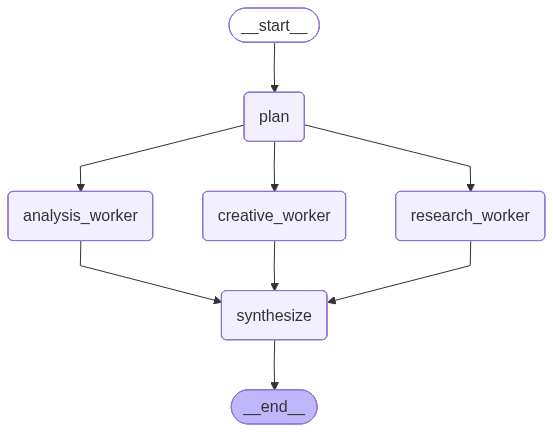

In [37]:
# State for orchestrator-worker pattern - using separate fields to avoid concurrent updates
class OrchestratorState(TypedDict):
    user_request: str
    plan: List[str]
    research_result: str
    analysis_result: str
    creative_result: str
    final_output: str

# Task planning schema for the orchestrator
class TaskPlan(BaseModel):
    tasks: List[str] = Field(description="List of specific tasks to complete the request")
    reasoning: str = Field(description="Explanation of why these tasks were chosen")

task_planner = llm.with_structured_output(TaskPlan)

def orchestrator_plan(state: OrchestratorState):
    """Orchestrator Step 1: Break down the request into tasks"""
    plan = task_planner.invoke(
        f"Break down this user request into 2-4 specific tasks: '{state['user_request']}'\\n\\n"
        "Available worker types:\\n"
        "- research: gather information and facts\\n"
        "- analysis: analyze data or compare information\\n"
        "- creative: generate creative content\\n"
        "- summary: synthesize and summarize information\\n\\n"
        "Create concrete, actionable tasks that workers can execute."
    )
    
    print(f"🎯 Orchestrator planned {len(plan.tasks)} tasks:")
    for i, task in enumerate(plan.tasks, 1):
        print(f"  {i}. {task}")
    print(f"📝 Reasoning: {plan.reasoning}")
    
    return {"plan": plan.tasks}

# Specialized Workers
def research_worker(state: OrchestratorState):
    """Research Worker: Gathers information"""
    research_tasks = [task for task in state["plan"] 
                     if any(keyword in task.lower() for keyword in ["research", "information", "find", "gather", "facts"])]
    
    if research_tasks:
        task = research_tasks[0]  # Take first matching task
        print(f"📚 Research Worker executing: {task}")
        msg = llm.invoke(f"Provide detailed, factual information for this research task: {task}")
        return {"research_result": msg.content}
    
    print("📚 Research Worker: No matching tasks found")
    return {"research_result": "No research tasks found"}

def analysis_worker(state: OrchestratorState):
    """Analysis Worker: Analyzes and compares"""
    analysis_tasks = [task for task in state["plan"] 
                     if any(keyword in task.lower() for keyword in ["analy", "compare", "evaluate", "assess", "examine"])]
    
    if analysis_tasks:
        task = analysis_tasks[0]
        print(f"🔍 Analysis Worker executing: {task}")
        msg = llm.invoke(f"Analyze this task thoroughly: {task}")
        return {"analysis_result": msg.content}
    
    print("🔍 Analysis Worker: No matching tasks found")
    return {"analysis_result": "No analysis tasks found"}

def creative_worker(state: OrchestratorState):
    """Creative Worker: Generates creative content"""
    creative_tasks = [task for task in state["plan"] 
                     if any(keyword in task.lower() for keyword in ["creat", "write", "story", "poem", "design", "imagine"])]
    
    if creative_tasks:
        task = creative_tasks[0]
        print(f"🎨 Creative Worker executing: {task}")
        msg = llm.invoke(f"Complete this creative task with engaging content: {task}")
        return {"creative_result": msg.content}
    
    print("🎨 Creative Worker: No matching tasks found")
    return {"creative_result": "No creative tasks found"}

def orchestrator_synthesize(state: OrchestratorState):
    """Orchestrator Step 2: Synthesize all worker results"""
    print("🎼 Orchestrator synthesizing results...")
    
    # Collect all worker results
    worker_results = []
    if state.get("research_result") and state["research_result"] != "No research tasks found":
        worker_results.append(f"RESEARCH WORKER RESULTS:\\n{state['research_result']}")
    if state.get("analysis_result") and state["analysis_result"] != "No analysis tasks found":
        worker_results.append(f"ANALYSIS WORKER RESULTS:\\n{state['analysis_result']}")
    if state.get("creative_result") and state["creative_result"] != "No creative tasks found":
        worker_results.append(f"CREATIVE WORKER RESULTS:\\n{state['creative_result']}")
    
    results_summary = "\\n\\n".join(worker_results)
    
    msg = llm.invoke(
        f"Synthesize these worker results into a comprehensive response for: '{state['user_request']}'\\n\\n"
        f"Worker Results:\\n{results_summary}\\n\\n"
        f"Create a cohesive, well-structured final response that addresses the original request."
    )
    return {"final_output": msg.content}

# Build orchestrator-worker workflow
orchestrator_workflow = StateGraph(OrchestratorState)

# Add nodes
orchestrator_workflow.add_node("plan", orchestrator_plan)
orchestrator_workflow.add_node("research_worker", research_worker)
orchestrator_workflow.add_node("analysis_worker", analysis_worker)
orchestrator_workflow.add_node("creative_worker", creative_worker)
orchestrator_workflow.add_node("synthesize", orchestrator_synthesize)

# Add edges
orchestrator_workflow.add_edge(START, "plan")

# KEY: Parallel worker execution after planning
orchestrator_workflow.add_edge("plan", "research_worker")
orchestrator_workflow.add_edge("plan", "analysis_worker")
orchestrator_workflow.add_edge("plan", "creative_worker")

# All workers feed into synthesis
orchestrator_workflow.add_edge("research_worker", "synthesize")
orchestrator_workflow.add_edge("analysis_worker", "synthesize")
orchestrator_workflow.add_edge("creative_worker", "synthesize")

orchestrator_workflow.add_edge("synthesize", END)

# Compile
orchestrator_app = orchestrator_workflow.compile()

print("🎯 Orchestrator-Worker Workflow Created!")
print("📚 Key Concept: Central coordination with specialized parallel workers")
orchestrator_app


In [38]:
# Test orchestrator-worker pattern
print("🎯 Testing Orchestrator-Worker Pattern:")
print("=" * 50)

user_request = "Create a comprehensive overview of renewable energy technologies"
print(f"📝 Request: {user_request}\\n")

result = orchestrator_app.invoke({"user_request": user_request})

print(f"\\n📋 Generated Plan ({len(result['plan'])} tasks):")
for i, task in enumerate(result["plan"], 1):
    print(f"  {i}. {task}")

print(f"\\n🔧 Worker Results:")
worker_results = [
    ("RESEARCH", result.get("research_result", "")),
    ("ANALYSIS", result.get("analysis_result", "")),
    ("CREATIVE", result.get("creative_result", ""))
]

for worker_type, result_content in worker_results:
    if result_content and not result_content.startswith("No "):
        print(f"\\n{worker_type}:")
        print(f"{result_content[:150]}...\\n")

print("\\n🎯 Final Synthesized Output:")
print("-" * 40)
print(result["final_output"])

print("\\n📚 Training Insight: Notice how the orchestrator coordinated multiple specialists to handle different aspects of the complex request!")


🎯 Testing Orchestrator-Worker Pattern:
📝 Request: Create a comprehensive overview of renewable energy technologies\n
🎯 Orchestrator planned 4 tasks:
  1. Research and gather information on existing renewable energy technologies, including solar, wind, hydro, and geothermal energy
  2. Analyze the data and compare the efficiency, cost, and environmental impact of each technology
  3. Create a visual representation, such as an infographic, to illustrate the benefits and drawbacks of each technology
  4. Synthesize the findings into a comprehensive overview of renewable energy technologies, including their current status, future prospects, and potential applications
📝 Reasoning: To create a comprehensive overview of renewable energy technologies, we need to gather information, analyze data, and synthesize the findings into a cohesive summary. The tasks are designed to utilize the strengths of different worker types, including research, analysis, creative, and summary workers.
🔍 Analysis W

### 📚 Theoretical Background: Evaluator-Optimizer Pattern

The [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/) introduces the **Evaluator-Optimizer pattern** as a quality-driven iterative approach:

#### 🔄 Core Concept:
The **Evaluator-Optimizer pattern** creates self-improving workflows through continuous evaluation and refinement cycles, ensuring outputs meet quality standards before completion.

#### 🎯 When to Use This Pattern:
- **Quality-Critical Applications**: Where output quality is paramount
- **Iterative Improvement**: Content/solutions can be systematically enhanced
- **Subjective Outputs**: Creative content, analysis, recommendations requiring refinement
- **Learning Systems**: Workflows that improve through feedback loops

#### 🔧 Key Components:
1. **Generator**: Creates initial content/solution
2. **Evaluator**: Assesses quality using defined criteria
3. **Feedback Loop**: Provides specific improvement guidance
4. **Termination Conditions**: Quality thresholds or iteration limits
5. **Optimizer**: Refines based on evaluation feedback

#### 💡 Quality Assessment Strategies:
- **Rule-based**: Checklist, requirements validation
- **Model-based**: Quality scoring models
- **LLM-based**: Intelligent evaluation with detailed feedback
- **Multi-criteria**: Score across multiple dimensions (clarity, accuracy, creativity)

#### 🏆 Business Applications:
- **Content Creation**: Blog posts, marketing copy, documentation
- **Code Generation**: Iteratively improve generated code quality
- **Strategy Development**: Refine business strategies through evaluation
- **Design Optimization**: UI/UX iterations based on usability criteria

#### ⚡ Benefits:
- **Quality Assurance**: Built-in quality control mechanism
- **Automatic Improvement**: Self-refining without manual intervention
- **Consistency**: Standardized evaluation criteria across all outputs
- **Learning**: Evaluation feedback improves future generations

#### 🔧 Implementation Pattern:
1. **Generate** → 2. **Evaluate** → 3. **Decision Point** → 4a. **Refine** (loop back) OR 4b. **Finalize** (complete)

**Let's implement a self-improving content generation system:**


## 7. Evaluator-Optimizer Pattern

**Learning Objective**: Learn how to create self-improving workflows through evaluation and optimization cycles.

This pattern implements iterative improvement where content is generated, evaluated, and refined until it meets quality standards.


🔄 Evaluator-Optimizer Workflow Created!
📚 Key Concept: Iterative loops with conditional exits based on quality metrics


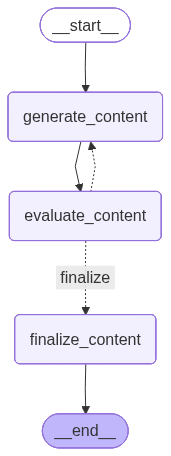

In [39]:
# State for evaluator-optimizer pattern
class OptimizerState(TypedDict):
    topic: str
    current_content: str
    feedback: str
    score: int
    iteration: int
    max_iterations: int
    is_acceptable: bool
    final_content: str

# Evaluation schema
class ContentEvaluation(BaseModel):
    score: int = Field(description="Quality score from 1-10", ge=1, le=10)
    feedback: str = Field(description="Specific feedback for improvement")
    is_acceptable: bool = Field(description="Whether content meets quality threshold (score >= 7)")

content_evaluator = llm.with_structured_output(ContentEvaluation)

def generate_content(state: OptimizerState):
    """Generator: Create or improve content based on feedback"""
    iteration = state.get("iteration", 0) + 1
    print(f"📝 Generation - Iteration {iteration}")
    
    if state.get("feedback"):
        prompt = (
            f"Improve this content about {state['topic']} based on the feedback:\\n\\n"
            f"Current content: {state['current_content']}\\n\\n"
            f"Feedback: {state['feedback']}\\n\\n"
            "Generate an improved version that addresses the feedback:"
        )
    else:
        prompt = f"Write engaging, high-quality content about {state['topic']}. Aim for clarity, accuracy, and interest."
    
    msg = llm.invoke(prompt)
    return {
        "current_content": msg.content,
        "iteration": iteration
    }

def evaluate_content(state: OptimizerState):
    """Evaluator: Assess content quality and provide feedback"""
    print(f"🔍 Evaluation - Iteration {state['iteration']}")
    
    evaluation = content_evaluator.invoke(
        f"Evaluate this content about {state['topic']}:\\n\\n"
        f"{state['current_content']}\\n\\n"
        "Rate on criteria: clarity (is it easy to understand?), engagement (is it interesting?), "
        "accuracy (is information correct?), completeness (covers the topic well?).\\n"
        "Score 1-10 overall. Consider content acceptable if score >= 7."
    )
    
    print(f"📊 Score: {evaluation.score}/10, Acceptable: {evaluation.is_acceptable}")
    print(f"💬 Feedback: {evaluation.feedback[:100]}...")
    
    return {
        "feedback": evaluation.feedback,
        "score": evaluation.score,
        "is_acceptable": evaluation.is_acceptable
    }

# KEY: Decision function for iterative loop
def should_continue_optimization(state: OptimizerState) -> str:
    """Decide whether to continue optimization or finalize"""
    # Stop conditions: acceptable quality OR max iterations reached
    if (state.get("is_acceptable", False) or 
        state.get("iteration", 0) >= state.get("max_iterations", 3)):
        
        if state.get("is_acceptable", False):
            print("✅ Content meets quality threshold - finalizing")
        else:
            print("⏰ Max iterations reached - finalizing")
        return "finalize"
    
    print("🔄 Quality threshold not met - continuing optimization")
    return "generate_content"

def finalize_content(state: OptimizerState):
    """Finalizer: Complete the optimization process"""
    print(f"🎯 Optimization complete after {state['iteration']} iterations")
    return {"final_content": state["current_content"]}

# Build evaluator-optimizer workflow
optimizer_workflow = StateGraph(OptimizerState)

# Add nodes
optimizer_workflow.add_node("generate_content", generate_content)
optimizer_workflow.add_node("evaluate_content", evaluate_content)
optimizer_workflow.add_node("finalize_content", finalize_content)

# Add edges
optimizer_workflow.add_edge(START, "generate_content")
optimizer_workflow.add_edge("generate_content", "evaluate_content")

# KEY: Conditional edge creates the optimization loop
optimizer_workflow.add_conditional_edges(
    "evaluate_content",
    should_continue_optimization,
    {
        "generate_content": "generate_content",  # Loop back for improvement
        "finalize": "finalize_content"          # Exit when done
    }
)
optimizer_workflow.add_edge("finalize_content", END)

# Compile
optimizer_app = optimizer_workflow.compile()

print("🔄 Evaluator-Optimizer Workflow Created!")
print("📚 Key Concept: Iterative loops with conditional exits based on quality metrics")
optimizer_app


In [40]:
# Test evaluator-optimizer pattern
print("🔄 Testing Evaluator-Optimizer Pattern:")
print("=" * 50)

topic = "artificial intelligence in healthcare"
print(f"📝 Topic: {topic}\\n")

# Run optimization process
result = optimizer_app.invoke({
    "topic": topic,
    "max_iterations": 3
})

print(f"\\n📈 Optimization Summary:")
print(f"  • Total iterations: {result['iteration']}")
print(f"  • Final score: {result.get('score', 'N/A')}/10")
print(f"  • Quality acceptable: {result.get('is_acceptable', 'N/A')}")

if result.get('feedback'):
    print(f"\\n💬 Final evaluation feedback:")
    print(f"  {result['feedback'][:200]}...")

print(f"\\n📋 Final Optimized Content:")
print("-" * 40)
print(result["final_content"])

print("\\n📚 Training Insight: The workflow automatically improved content quality through iterative evaluation and refinement!")


🔄 Testing Evaluator-Optimizer Pattern:
📝 Topic: artificial intelligence in healthcare\n
📝 Generation - Iteration 1
🔍 Evaluation - Iteration 1
📊 Score: 9/10, Acceptable: True
💬 Feedback: The content is well-structured, clear, and engaging, providing a comprehensive overview of the appli...
✅ Content meets quality threshold - finalizing
🎯 Optimization complete after 1 iterations
\n📈 Optimization Summary:
  • Total iterations: 1
  • Final score: 9/10
  • Quality acceptable: True
\n💬 Final evaluation feedback:
  The content is well-structured, clear, and engaging, providing a comprehensive overview of the applications and potential of artificial intelligence in healthcare. The use of specific examples and exp...
\n📋 Final Optimized Content:
----------------------------------------
**Revolutionizing Healthcare: The Power of Artificial Intelligence**

Artificial intelligence (AI) is transforming the healthcare landscape, bringing about unprecedented advancements in patient care, disease diag

### 📚 Theoretical Background: Agent Workflows

The [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/) presents **Agents** as the most sophisticated workflow pattern:

> **"Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully."**

#### 🤖 Core Concept:
**Agents** are autonomous systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks through environmental feedback loops.

#### 🎯 When to Use Agents:
> **"Agents can be used for open-ended problems where it's difficult or impossible to predict the required number of steps, and where you can't hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments."**

#### 🔧 Key Components:
1. **Tool Selection**: Agent chooses which tools to use dynamically
2. **Environmental Feedback**: Results from tool usage inform next decisions
3. **Reasoning Loop**: Continuous think-act-observe-think cycle
4. **Autonomous Decision Making**: Agent controls its own execution path

#### 🏗️ Implementation Pattern:
1. **LLM Call**: Agent analyzes situation and decides on action
2. **Tool Execution**: If tools needed, execute them and get results
3. **Feedback Integration**: Tool results become part of agent's context
4. **Continue or Conclude**: Agent decides whether more actions needed

#### 💡 Critical Design Considerations:
- **Tool Documentation**: Clear, comprehensive tool descriptions are crucial
- **Error Handling**: Agents must gracefully handle tool failures
- **Safety Bounds**: Prevent runaway execution or harmful actions
- **Trust Level**: Degree of autonomy depends on environment trust

#### 🌟 Advantages:
- **Flexibility**: Can handle unpredictable, multi-step problems
- **Adaptability**: Adjusts strategy based on intermediate results
- **Scalability**: Same agent can handle diverse task variations
- **Autonomy**: Minimal hand-coding of execution paths

**Let's build an autonomous agent that dynamically selects and uses tools:**


## 8. Agent Workflow

**Learning Objective**: Understand autonomous agents that dynamically use tools based on environmental feedback.

An autonomous agent that can use tools to solve problems dynamically. This is the most flexible pattern, where the LLM decides which tools to use and when.


🤖 Agent Workflow Created!


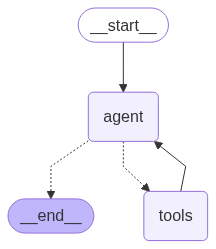

In [41]:
# Agent implementation
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant that can perform mathematical calculations. "
                        "Use the available tools when needed to solve problems accurately."
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: MessagesState):
    """Execute tool calls"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue_agent(state: MessagesState) -> Literal["tools", "__end__"]:
    """Decide whether to use tools or end"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# Build agent workflow
agent_workflow = StateGraph(MessagesState)

# Add nodes
agent_workflow.add_node("agent", llm_call)
agent_workflow.add_node("tools", tool_node)

# Add edges
agent_workflow.add_edge(START, "agent")
agent_workflow.add_conditional_edges(
    "agent",
    should_continue_agent,
    {
        "tools": "tools",
        "__end__": END,
    },
)
agent_workflow.add_edge("tools", "agent")

# Compile the agent
agent_app = agent_workflow.compile()

print("🤖 Agent Workflow Created!")
agent_app


In [42]:
# Test agent with complex calculations
print("🤖 Testing Agent with Tool Calling:")
print("=" * 50)

test_queries = [
    "What is 15 multiplied by 23?",
    "Calculate (45 + 67) divided by 4",
    "What's the result of 8 * 9 + 12?"
]

for i, query in enumerate(test_queries, 1):
    print(f"\n{i}. Query: {query}")
    print("-" * 30)
    
    messages = [HumanMessage(content=query)]
    result = agent_app.invoke({"messages": messages})
    
    for message in result["messages"]:
        if hasattr(message, 'content') and message.content:
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"🤖 Agent: Making tool calls...")
                for tool_call in message.tool_calls:
                    print(f"   🔧 {tool_call['name']}({tool_call['args']})")
            elif message.content and not hasattr(message, 'tool_call_id'):
                print(f"🤖 Agent: {message.content}")
            elif hasattr(message, 'tool_call_id'):
                print(f"🔧 Tool result: {message.content}")


🤖 Testing Agent with Tool Calling:

1. Query: What is 15 multiplied by 23?
------------------------------
🤖 Agent: What is 15 multiplied by 23?
🔧 Tool result: 345
🤖 Agent: The result of 15 multiplied by 23 is 345.

2. Query: Calculate (45 + 67) divided by 4
------------------------------
🤖 Agent: Calculate (45 + 67) divided by 4
🔧 Tool result: 112
🔧 Tool result: 28.0
🤖 Agent: First, we need to calculate the sum of 45 and 67, which equals 112. Then, we divide 112 by 4, resulting in 28.0.

3. Query: What's the result of 8 * 9 + 12?
------------------------------
🤖 Agent: What's the result of 8 * 9 + 12?
🔧 Tool result: 72
🔧 Tool result: 120
🤖 Agent: The result of 8 * 9 is 72, then 72 + 12 is 84.


## 5. Pre-built Agent (ReAct Pattern)

LangGraph provides pre-built agents that implement common patterns.


🏗️ Pre-built ReAct Agent Created!

🧪 Testing Pre-built Agent:
Query: I need to calculate the area of a rectangle that is 12 units wide and 8 units tall

Agent reasoning and responses:

🤖 Agent: I need to calculate the area of a rectangle that is 12 units wide and 8 units tall
🔧 Tool result: 96

🤖 Agent: The area of the rectangle is 96 square units.


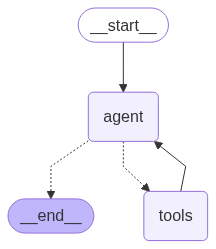

In [43]:
# Create a pre-built ReAct agent
prebuilt_agent = create_react_agent(llm, tools=tools)

print("🏗️ Pre-built ReAct Agent Created!")
print("\n🧪 Testing Pre-built Agent:")
print("=" * 40)

# Test the pre-built agent
query = "I need to calculate the area of a rectangle that is 12 units wide and 8 units tall"
print(f"Query: {query}\n")

messages = [HumanMessage(content=query)]
result = prebuilt_agent.invoke({"messages": messages})

print("Agent reasoning and responses:")
for message in result["messages"]:
    if hasattr(message, 'content') and message.content:
        if hasattr(message, 'tool_calls') and message.tool_calls:
            print(f"\n🤖 Agent is using tools:")
            for tool_call in message.tool_calls:
                print(f"   🔧 {tool_call['name']}({tool_call['args']})")
        elif not hasattr(message, 'tool_call_id'):
            print(f"\n🤖 Agent: {message.content}")
        else:
            print(f"🔧 Tool result: {message.content}")
prebuilt_agent            


## 6. Advanced Tools and Extensions

Let's add some more sophisticated tools to showcase agent capabilities.


🚀 Advanced Agent with Enhanced Tools Created!
Available tools: ['add', 'multiply', 'divide', 'get_weather', 'calculate_compound_interest', 'analyze_text']


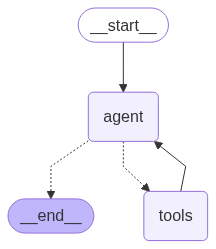

In [44]:
import json
import random
from datetime import datetime

# Clear any potential conflicts by importing fresh tool decorator
from langchain_core.tools import tool

# Advanced tools
@tool
def get_weather(city: str) -> str:
    """Get weather information for a city (simulated).
    
    Args:
        city: The city name
    """
    # Simulate weather data
    conditions = ["sunny", "cloudy", "rainy", "partly cloudy"]
    temp = random.randint(10, 35)
    condition = random.choice(conditions)
    
    return f"Weather in {city}: {temp}°C, {condition}"

@tool
def calculate_compound_interest(principal: float, rate: float, time: int, frequency: int = 1) -> str:
    """Calculate compound interest.
    
    Args:
        principal: Initial amount
        rate: Annual interest rate (as decimal, e.g., 0.05 for 5%)
        time: Time period in years
        frequency: Compounding frequency per year (default 1)
    """
    amount = principal * (1 + rate/frequency) ** (frequency * time)
    interest = amount - principal
    
    result = {
        "principal": principal,
        "final_amount": round(amount, 2),
        "interest_earned": round(interest, 2),
        "rate_percent": rate * 100,
        "years": time
    }
    
    return f"Compound Interest Calculation: Principal ${result['principal']}, Rate {result['rate_percent']}%, Time {result['years']} years → Final Amount: ${result['final_amount']}, Interest Earned: ${result['interest_earned']}"

@tool
def analyze_text(text: str) -> str:
    """Analyze text and provide statistics.
    
    Args:
        text: Text to analyze
    """
    words = text.split()
    sentences = text.split('.')
    
    stats = {
        "character_count": len(text),
        "word_count": len(words),
        "sentence_count": len([s for s in sentences if s.strip()]),
        "average_word_length": round(sum(len(word) for word in words) / len(words), 2) if words else 0,
        "longest_word": max(words, key=len) if words else ""
    }
    
    return f"Text Analysis: {stats['character_count']} characters, {stats['word_count']} words, {stats['sentence_count']} sentences, avg word length {stats['average_word_length']}, longest word '{stats['longest_word']}'"

# Create enhanced agent with advanced tools
advanced_tools = [add, multiply, divide, get_weather, calculate_compound_interest, analyze_text]
advanced_agent = create_react_agent(llm, tools=advanced_tools)

print("🚀 Advanced Agent with Enhanced Tools Created!")
print(f"Available tools: {[tool.name for tool in advanced_tools]}")
advanced_agent


In [45]:
# Test advanced agent with complex queries
print("🚀 Testing Advanced Agent:")
print("=" * 50)

complex_queries = [
    "Calculate how much $5000 will grow to in 10 years at 6% annual interest",
    "Analyze this text: 'The quick brown fox jumps over the lazy dog. This sentence contains every letter.'",
    "What's the weather like in Tokyo and also calculate 25 * 16?"
]

for i, query in enumerate(complex_queries, 1):
    print(f"\n{'='*10} Query {i} {'='*10}")
    print(f"❓ {query}")
    print("-" * 50)
    
    messages = [HumanMessage(content=query)]
    result = advanced_agent.invoke({"messages": messages})
    
    # Show the conversation flow
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            continue  # Skip showing user input again
        elif hasattr(message, 'tool_calls') and message.tool_calls:
            print("🤖 Agent is thinking and using tools...")
            for tool_call in message.tool_calls:
                print(f"   🔧 {tool_call['name']}({tool_call['args']})")
        elif hasattr(message, 'tool_call_id'):
            print(f"   📊 Tool result: {message.content}")
        elif hasattr(message, 'content') and message.content:
            print(f"\n✅ Final Answer: {message.content}")
    
    print("\n")


🚀 Testing Advanced Agent:

========== Query 1 ==========
❓ Calculate how much $5000 will grow to in 10 years at 6% annual interest
--------------------------------------------------
🤖 Agent is thinking and using tools...
   🔧 calculate_compound_interest({'principal': 5000, 'rate': 0.06, 'time': 10})
   📊 Tool result: Compound Interest Calculation: Principal $5000.0, Rate 6.0%, Time 10 years → Final Amount: $8954.24, Interest Earned: $3954.24

✅ Final Answer: The final amount after 10 years at 6% annual interest is $8954.24, with $3954.24 earned in interest.



========== Query 2 ==========
❓ Analyze this text: 'The quick brown fox jumps over the lazy dog. This sentence contains every letter.'
--------------------------------------------------
🤖 Agent is thinking and using tools...
   🔧 analyze_text({'text': 'The quick brown fox jumps over the lazy dog. This sentence contains every letter.'})
   📊 Tool result: Text Analysis: 81 characters, 14 words, 2 sentences, avg word length 4.86, lo

## 7. Workflow Patterns Summary


## 🎓 Training Complete: From Workflows to Agents

**Congratulations!** You've mastered the complete spectrum of agentic AI patterns using LangGraph and Groq.

### What You've Built:

| Pattern | Complexity | Key Learning |
|---------|------------|--------------|
| 🏗️ **Building Blocks** | ⭐ Beginner | Structured outputs & tool calling foundation |
| 🔗 **Prompt Chaining** | ⭐⭐ Intermediate | Sequential processing with quality gates |
| ⚡ **Parallelization** | ⭐⭐ Intermediate | Concurrent execution for performance |
| 🧭 **Routing** | ⭐⭐⭐ Advanced | Intelligent input classification & handling |
| 🎯 **Orchestrator-Worker** | ⭐⭐⭐⭐ Expert | Complex coordination with specialists |
| 🔄 **Evaluator-Optimizer** | ⭐⭐⭐⭐ Expert | Self-improving quality-driven systems |
| 🤖 **Agents** | ⭐⭐⭐⭐⭐ Master | Autonomous tool-using systems |

### 🚀 You're Now Ready For:

- **Architecture Decisions**: Choose optimal patterns for any use case  
- **Performance Optimization**: Leverage parallelization and routing
- **Quality Systems**: Implement evaluation and improvement loops
- **Autonomous Solutions**: Deploy intelligent agents with confidence

### 📚 Continue Learning:

- **[LangGraph Documentation](https://langchain-ai.github.io/langgraph/)** - Advanced features & deployment
- **[Groq Documentation](https://console.groq.com/docs)** - Model optimization & scaling
- **[LangChain Academy](https://academy.langchain.com/)** - Structured learning paths

**Keep building the future of AI! 🌟**
